In [348]:
# Audio preprocessing
import librosa
import soundfile as sf
import numpy as np
from pydub import AudioSegment
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [133]:
def load_audio(file_path, target_sr=16000):
    """
    Load a WAV audio file and resample it to a fixed sampling rate.
    
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sampling rate (default: 16kHz).
    
    Returns:
        y (numpy array): Audio waveform.
        sr (int): Sampling rate of the loaded audio.
    """
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

In [134]:
def rms_normalization(audio, target_rms=0.1):
    """
    Normalize the audio signal to a fixed RMS (Root Mean Square) value.

    Args:
        audio (numpy array): Input audio waveform.
        target_rms (float): Target RMS level.

    Returns:
        y_norm (numpy array): RMS-normalized audio waveform.
    """
    rms = np.sqrt(np.mean(audio**2))  # Compute current RMS
    scaling_factor = target_rms / (rms + 1e-10)  # Avoid division by zero
    y_norm = audio * scaling_factor  # Scale audio to match target RMS

    return y_norm

In [394]:
def calculate_features(audio_path):
    y, sr = load_audio(audio_path)  # Load and resample
    y_norm = rms_normalization(y)  # Normalize volume
    features = {}
    # --- 1. MFCCs ---
    mfccs = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    features['mfccs'] = mfccs_mean
    
    # --- 2. Spectral Entropy ---
    spec = np.abs(librosa.stft(y_norm, n_fft=2048))
    col_sums = np.sum(spec, axis=0, keepdims=True)

    # Prevent division by zero
    col_sums[col_sums == 0] = 1e-10
    prob_dist = spec / col_sums

    entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10), axis=0)
    features['spectral_entropy'] = np.mean(entropy)

    
    # --- 3. Zero-Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y_norm)
    features['zcr'] = np.mean(zcr)
    
    # --- 4. Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y_norm, sr=sr)
    features['spectral_centroid'] = np.mean(centroid)
    
    # ✅ 5. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_norm, sr=sr)
    bandwidth_mean = np.mean(spectral_bandwidth)
    features['spectral_bandwith'] = bandwidth_mean
    
     # Combine into a single feature vector
    feature_vector = np.concatenate([
        features['mfccs'],
        [features['spectral_entropy']],
        [features['zcr']],
        [features['spectral_centroid']],
        [features['spectral_bandwith']]
    ])
    return feature_vector

In [521]:
audios = [
    "splits/teacher1.wav",
    "splits/teacher2.wav",
    "splits/teacher3.wav",
    "splits/teacher4.wav",
    "splits/teacher5.wav",
    "splits/teacher6.wav",
    "splits/teacher7.wav",
    "splits/teacher8.wav",
    "splits/teacher9.wav",
    "splits/teacher10.wav",
    "splits/student.wav",
    "splits/student2.wav",
    "splits/student3.wav",
]
X = [calculate_features(audio) for audio in audios]

In [522]:
print(X)

[array([-1.51483124e+02,  1.10787415e+02,  1.08039637e+01,  1.99081993e+01,
        2.44549155e+00,  5.19755888e+00, -1.59640188e+01,  2.28338981e+00,
       -1.60384140e+01,  9.31734219e-02, -1.31271811e+01,  1.89642286e+00,
       -1.08770657e+01,  7.97937775e+00,  6.75285299e-02,  1.33858292e+03,
        1.65109696e+03]), array([-1.45816269e+02,  1.26320602e+02,  1.08464432e+01,  1.35187941e+01,
        8.40602040e-01,  2.58563972e+00, -1.83437252e+01,  6.26017749e-02,
       -1.62399540e+01,  4.22993326e+00, -1.32890387e+01, -2.51331925e+00,
       -1.31313353e+01,  7.93666792e+00,  6.45630522e-02,  1.19174966e+03,
        1.56359761e+03]), array([-1.37528351e+02,  1.17009850e+02,  1.54118738e+01,  1.31893024e+01,
       -1.54211760e+00,  6.30328703e+00, -1.55510635e+01,  2.97386670e+00,
       -1.86613426e+01,  2.16737914e+00, -1.39969578e+01,  3.02279973e+00,
       -1.14668560e+01,  8.04934216e+00,  6.53683328e-02,  1.30752277e+03,
        1.69644905e+03]), array([-1.38625046e+0

In [523]:
X = np.array(X)

In [524]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled

array([[-1.02449733, -0.41533827, -0.48116947,  0.09949764,  1.77140979,
        -0.38403236, -0.35163529,  0.25408413, -0.11331154, -1.04038506,
        -0.77243741, -0.16534312,  0.28522234, -0.49103545, -0.23911778,
        -0.0109743 , -0.13221062],
       [-0.65527458,  1.11125894, -0.4728457 , -1.10327332,  0.87451523,
        -1.36339456, -1.08028627, -0.66762633, -0.17602096,  0.86182219,
        -0.84417171, -1.73574983, -1.02993969, -0.7196628 , -0.49629929,
        -0.89808585, -0.94665509],
       [-0.115277  ,  0.19620084,  0.42174018, -1.16529834, -0.45707069,
         0.03057019, -0.225191  ,  0.54065798, -0.92943912, -0.08660255,
        -1.15791713,  0.2357846 , -0.05886688, -0.11651327, -0.4264612 ,
        -0.19862812,  0.28992688],
       [-0.18673193, -1.09389432,  1.44888965, -0.03244282, -0.97883407,
         0.03770516,  0.0246014 ,  0.73144723, -0.19697475, -0.0743697 ,
        -0.68461023, -0.61024722, -1.01619871,  0.25734525,  0.95367229,
         1.07718902

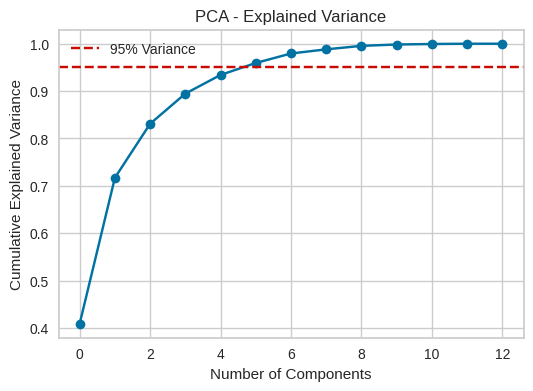

📉 Number of components to retain 95% variance: 6


In [525]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is your scaled (standardized) 1024-dim embeddings
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Get number of components to retain 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"📉 Number of components to retain 95% variance: {n_components_95}")

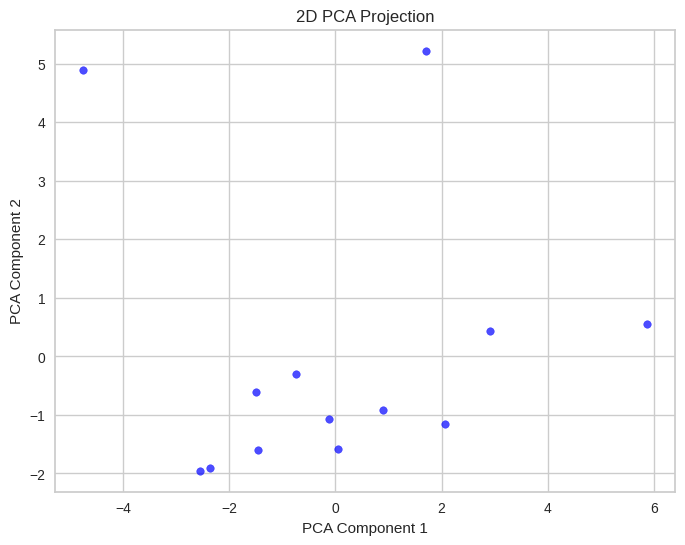

In [526]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# Visualize: color first 11 as one group

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', s=30, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection')
plt.grid(True)
plt.show()

🔍 Chosen eps: 2.668122141096102


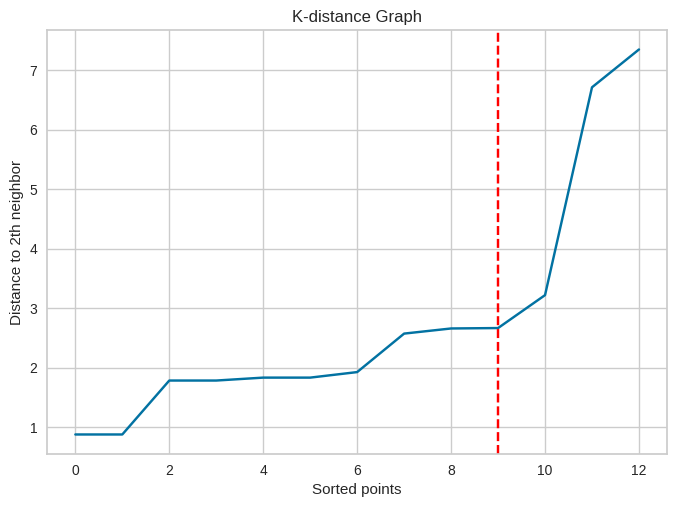

3.2208035792241496


In [528]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Let's say X_2d is your data after PCA (shape: [n_samples, n_components])
k = 2  # min_samples for DBSCAN (or set to any expected density threshold)

# Step 1: Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)

# Step 2: Calculate distances to the k-th nearest neighbor
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
# Step 3: Find elbow point (i.e. best eps)
kneedle = KneeLocator(
    range(len(distances)),
    distances,
    curve="convex",
    direction="increasing",
    S=1# Try decreasing this sensitivity parameter
)

# Step 4: This is your automated eps
epsilon = distances[kneedle.elbow]
print("🔍 Chosen eps:", epsilon)

# Optional: Plot the knee
plt.plot(distances)
plt.axvline(x=kneedle.elbow, color='red', linestyle='--')
plt.title("K-distance Graph")
plt.xlabel("Sorted points")
plt.ylabel("Distance to {}th neighbor".format(k))
plt.show()
distances_array = np.array(distances)
acceleration = np.diff(np.diff(distances_array))
elbow_index = np.argmax(acceleration) + 1
epsilon = distances[elbow_index]
print(epsilon)

In [534]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=2.668122141096102, min_samples=2)
labels = clusterer.fit_predict(X_pca)
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1])

In [539]:
import hdbscan

# Now cluster on the PCA-reduced data
clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=6,min_cluster_size=2,min_samples=2,allow_single_cluster=True,prediction_data=True)
labels = clusterer.fit_predict(X_pca)
labels

/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1])

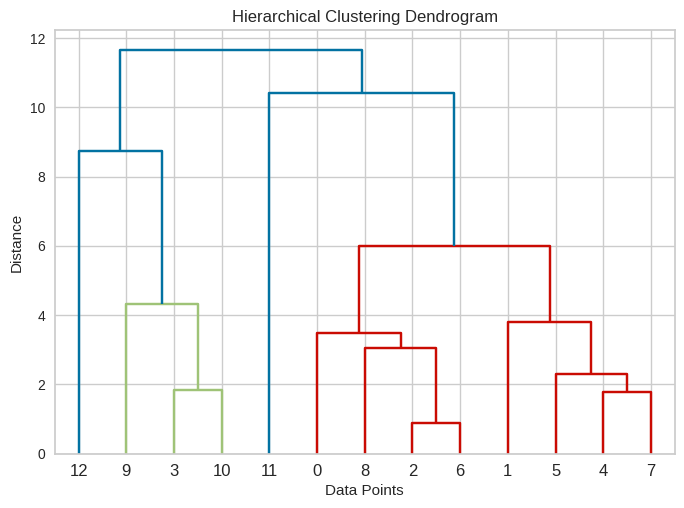

In [540]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(X_pca, method='ward')
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [541]:
import numpy as np

def find_optimal_dendrogram_cut(Z):
    """
    Finds the optimal cut height for a dendrogram based on the largest vertical gap
    between merge distances (the elbow method).
    
    Parameters:
        Z (ndarray): The linkage matrix from scipy.cluster.hierarchy.linkage.
        
    Returns:
        float: Optimal cut height.
    """
    # Extract merge distances from linkage matrix
    distances = Z[:, 2]
    
    # Compute the difference between successive merge heights
    gaps = np.diff(distances)
    
    # Find the largest gap and its index
    max_gap_idx = np.argmax(gaps)
    
    # Cut height = just before the largest merge
    optimal_cut_height = distances[max_gap_idx] + 1e-5  # tiny epsilon to stay below the merge

    return optimal_cut_height
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(X_scaled, method='ward')  # your linkage matrix
cut_height = find_optimal_dendrogram_cut(Z)

print(f"Optimal cut height: {cut_height:.2f}")

# Use it to extract cluster labels
cluster_labels = fcluster(Z, t=cut_height, criterion='distance')
cluster_labels


Optimal cut height: 6.03


array([3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 4, 2], dtype=int32)